<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/mini_batch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

--2023-08-13 06:52:47--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2023-08-13 06:52:47--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.1s    

2023-08-13 06:52:47 (118 MB/s) - 

In [2]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from torch import tensor, nn
import torch.nn.functional as F

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('/content')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [7]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [8]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [9]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [10]:
def log_softmax(x): return x - (x.exp().sum(-1, keepdim=True)).log()

In [11]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x-m[:, None]).exp().sum(-1, keepdim=True).log()

In [12]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [13]:
# test_close(logsumexp(pred), pred.logsumexp(-1, keepdim=True))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [14]:
y_train[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [16]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [17]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [18]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [19]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [20]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

In [21]:
loss_func = F.cross_entropy

In [22]:
bs = 50

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [23]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [24]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [25]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [26]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [27]:
accuracy(preds, yb)

tensor(0.08)

In [28]:
lr = 0.5
epochs = 3

In [29]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [30]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [31]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

  report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


In [32]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [33]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [34]:
m1.named_children()

<generator object Module.named_children at 0x795e1b7b0f20>

In [35]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [36]:
class MLP(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    self.relu = nn.ReLU()

  def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [37]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [39]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [40]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [41]:
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, i+bs))
      xb, yb = x_train[s], y_train[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad * lr
        model.zero_grad()

    report(loss, preds, yb)

In [42]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [43]:
class MyModule:
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)

  def __setattr__(self, k, v):
    if not k.startswith("_"): self._modules[k] = v
    super().__setattr__(k, v)

  def __repr__(self): return f'{self._modules}'

  def parameters(self):
    for l in self._modules.values(): yield from l.parameters()

In [44]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [45]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [46]:
from functools import reduce

In [47]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [48]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

  def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

In [49]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
model(xb).shape

torch.Size([50, 10])

In [51]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)

  def forward(self, x):
    for l in self.layers: x = l(x)
    return x

In [52]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [53]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


In [54]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [55]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, 0.96
0.11, 0.96
0.09, 0.94


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [56]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [57]:
class Optimizer():
  def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr

  def step(self):
    with torch.no_grad():
      for p in self.params: p -= p.grad * self.lr

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [58]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [59]:
opt = Optimizer(model.parameters())

In [60]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n,i+bs))
    xb,yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In [61]:
from torch import optim

In [62]:
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [63]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [64]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


In [65]:
class Dataset():
  def __init__(self, x, y): self.x, self.y = x,y
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]

In [66]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [67]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [68]:
model, opt = get_model()

In [69]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    xb, yb = train_ds[i:min(n,i+bs)]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


In [70]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):yield self.ds[i:i+bs]

In [71]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [76]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [73]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

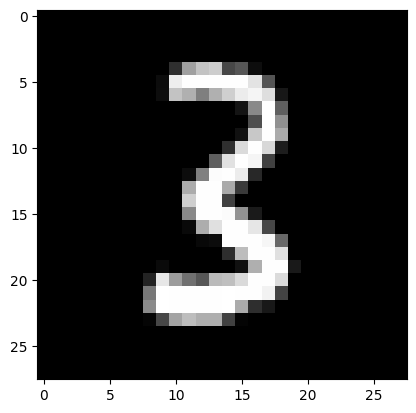

In [74]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [77]:
model, opt = get_model()

In [78]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    report(loss, preds, yb)

In [80]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.04, 0.98
0.05, 0.98
0.04, 1.00


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))